# Matter-Antimatter asymmetries at the LHC
## Lab Experiment

Author: Ahmad Abdelhakam Mahmoud

### Configuration
The cell below imports all required Python modules.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Input data
This opens input data files and assigns them to variables.

In [2]:
path = '../shared/' # set this to '' to run on the GitHub version
events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

In [16]:
kaon_rest_mass_mev = 493.677
kaon_rest_mass_mev_unc = 0.016

### Selecting data and calculating derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) are calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [35]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
ProbK = []
ProbPi = []

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events. 
# It is recommended to keep the number of events limited while developing the analysis.
MAX_EVENTS = 50000

# Select which set of input data is to be analysed. Uncomment exactly one line
trees = [events_sim['PhaseSpaceTree']]                       # Simulation
#trees = [events_down[b'DecayTree']]                          # Magnet down data
#trees = [events_up['DecayTree']]                             # Magnet up data
#trees = [events_down[b'DecayTree'],events_up['DecayTree']]   # Magnet down+up data

# This loop goes over the trees to be analysed
for tree in trees:
    # This outer loop is a technical loop of uproot over chunks of events
    for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
        # As Python can handle calculations with arrays, we can calculate derived quantities here
        pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
        pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
        pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)

        # Your invariant mass calculation should go here
        
        # This loop will go over individual events
        for i in range(0,len(data[b'H1_PZ'])):
            event_counter += 1
            if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
            if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
            # Decide here which events to analyse
            if (data[b'H1_PZ'][i] < 0) or (data[b'H2_PZ'][i] < 0) or (data[b'H3_PZ'][i] < 0): continue
            # Fill arrays of events to be plotted and analysed further below
            # Adding values for all three hadrons to the same variable here
            pT.append(pT_H1[i])
            pT.append(pT_H2[i])
            pT.append(pT_H3[i])
            pX.append(data[b'H1_PX'][i])
            pX.append(data[b'H2_PX'][i])
            pX.append(data[b'H3_PX'][i])
            pY.append(data[b'H1_PY'][i])
            pY.append(data[b'H2_PY'][i])
            pY.append(data[b'H3_PY'][i])
            pZ.append(data[b'H1_PZ'][i])
            pZ.append(data[b'H2_PZ'][i])
            pZ.append(data[b'H3_PZ'][i])
            
            ProbK.append(data[b'H1_ProbK'][i])
            ProbPi.append(data[b'H1_ProbPi'][i])
            ProbK.append(data[b'H2_ProbK'][i])
            ProbPi.append(data[b'H2_ProbPi'][i])
            ProbK.append(data[b'H3_ProbK'][i])
            ProbPi.append(data[b'H3_ProbPi'][i])
 
print('Read {:d} events'.format(event_counter))

Input data variables:
[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']
Read 50000 events


### Data Visualization
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram
Plotting 2D histogram


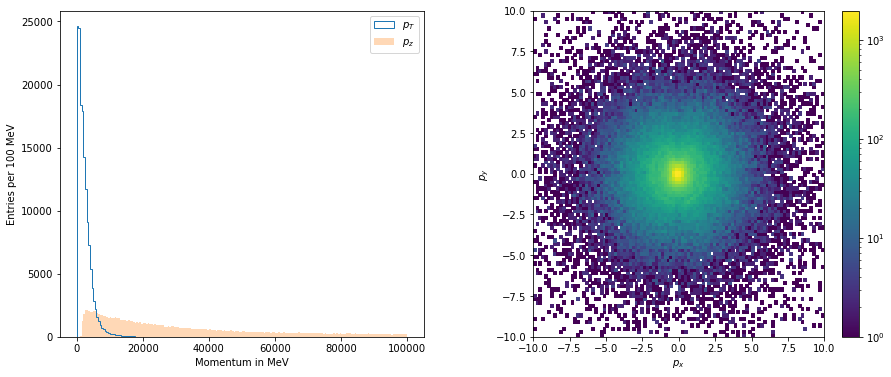

In [7]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel(r'$p_{x}$')
ax[1].set_ylabel(r'$p_{y}$')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

Plotting 2D histogram


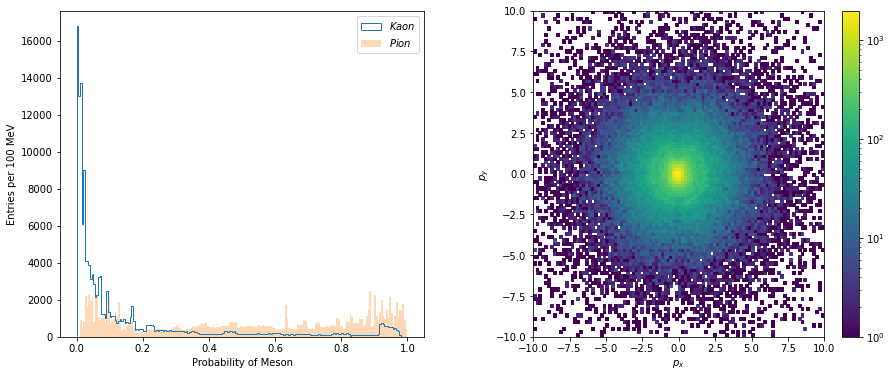

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
values_ProbK,bins_ProbK,patches_ProbK = ax[0].hist(ProbK, bins = 200, range = [0, 1],histtype='step',label='$Kaon$')
ax[0].hist(ProbPi, bins = 200, range = [0, 1],histtype='stepfilled',alpha=0.3,label='$Pion$')
ax[0].set_xlabel('Probability of Meson')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel(r'$p_{x}$')
ax[1].set_ylabel(r'$p_{y}$')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

 ### Invariant Mass Reconstruction

In [72]:
momentum_mag_H1 = np.sqrt(np.square(data[b'H1_PX']) + np.square(data[b'H1_PY']) + np.square(data[b'H1_PZ']))
momentum_mag_H2 = np.sqrt(np.square(data[b'H2_PX']) + np.square(data[b'H2_PY']) + np.square(data[b'H2_PZ']))
momentum_mag_H3 = np.sqrt(np.square(data[b'H3_PX']) + np.square(data[b'H3_PY']) + np.square(data[b'H3_PZ']))

def find_individual_energies (momentum, rest_mass):
    
    return np.sqrt(np.square(rest_mass) + np.square(momentum))

energies_kaon_H1 = find_individual_energies(momentum_mag_H1, kaon_rest_mass_mev)
energies_kaon_H2 = find_individual_energies(momentum_mag_H2, kaon_rest_mass_mev)
energies_kaon_H3 = find_individual_energies(momentum_mag_H3, kaon_rest_mass_mev)

def find_invariant_mass (momenta):
    
    invariant_mass = np.sqrt(np.square(energies_kaon_H1+energies_kaon_H2+energies_kaon_H3) - (np.square(data[b'H1_PX']+data[b'H2_PX']+data[b'H3_PX']) + np.square(data[b'H1_PY']+data[b'H2_PY']+data[b'H3_PY']) + np.square(data[b'H1_PZ']+data[b'H2_PZ']+data[b'H3_PZ'])))
    
    return invariant_mass

invariant_mass_B_meson = find_invariant_mass(momentum_mag)

In [73]:
print(invariant_mass_B_meson)

[5279.2432705  5279.25207873 5279.23223205 ... 5279.24491491 5279.25405307
 5279.2531522 ]


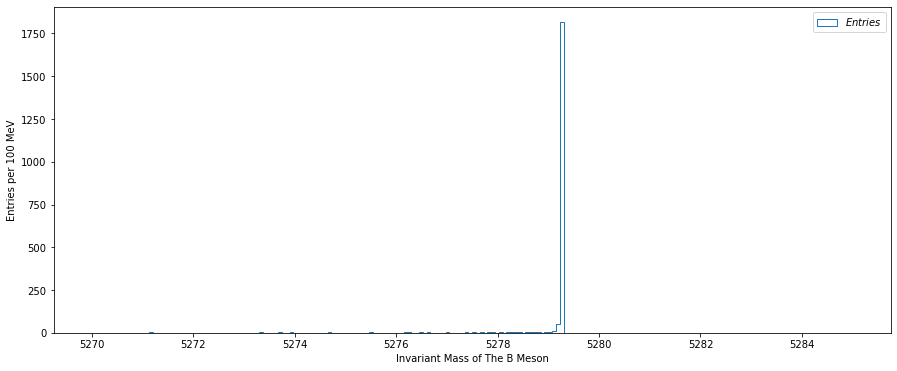

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
#fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
ax.hist(invariant_mass_B_meson, bins = 200, range = [5270,5285],histtype='step',label='$Entries$')
ax.set_xlabel('Invariant Mass of The B Meson')
ax.set_ylabel('Entries per 100 MeV')
ax.legend()
plt.savefig('pTpZ.pdf')